# DRD2 Activity Analysis

In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


## Imports

In [2]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from irelease.utils import generate_smiles, canonical_smiles
import nb_utils as nbu
from math import ceil
from sklearn.manifold import TSNE
import pandas as pd
import rdkit.Chem as Chem
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw

RDKit WARNING: [22:25:51] Enabling RDKit 2019.09.3 jupyter extensions


mol_metrics: reading NP model ...
loaded in 0.24085140228271484
mol_metrics: reading SA model ...
loaded in 1.0373563766479492


In [3]:
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

## Load SMILES files

In [4]:
ppo_grl_train = 'drd2/DRD2_activity_IReLeaSE-PPO_with_irl.json'
ppo_grl_eval = 'drd2/DRD2_activity_smiles_biased_ppo_grl_eval.json'
ppo_baseline_reward_train = 'drd2/DRD2_activity_IReLeaSE-PPO__baseline_reward_.json'
ppo_baseline_reward_eval = 'drd2/DRD2_activity_smiles_biased_ppo_baseline_reward_eval.json'
reinforce_train = 'drd2/DRD2_activity_IReLeaSE-REINFORCE_no_irl.json'
reinforce_eval = 'drd2/DRD2_activity_smiles_biased_reinforce_eval.json'
reinforce_grl_train = 'drd2/DRD2_activity_IReLeaSE-REINFORCE_with_irl.json'
reinforce_grl_eval = 'drd2/DRD2_activity_smiles_biased_reinforce_grl_eval.json'

In [5]:
ppo_grl_smiles_valid,  ppo_grl_smiles_invalid = nbu.smiles_from_json_data(ppo_grl_eval)
ppo_grl_conv = nbu.get_convergence_data(ppo_grl_train)
ppo_baseline_reward_smiles_valid, ppo_baseline_reward_smiles_invalid = nbu.smiles_from_json_data(ppo_baseline_reward_eval)
ppo_baseline_reward_conv = nbu.get_convergence_data(ppo_baseline_reward_train)
reinforce_smiles_valid, reinforce_smiles_invalid = nbu.smiles_from_json_data(reinforce_eval)
reinforce_conv = nbu.get_convergence_data(reinforce_train)
reinforce_grl_smiles_valid, reinforce_grl_smiles_invalid = nbu.smiles_from_json_data(reinforce_grl_eval)
reinforce_grl_conv = nbu.get_convergence_data(reinforce_grl_train)
len(ppo_grl_smiles_valid), len(ppo_baseline_reward_smiles_valid), len(reinforce_smiles_valid), len(reinforce_grl_smiles_valid)

(3271, 4544, 7405, 542)

In [6]:
# CSV files containing predictions/evaluations
preds_ppo_grl_eval = pd.read_csv('drd2/DRD2_activity_smiles_biased_ppo_grl_eval.csv')
preds_ppo_baseline_reward_eval = pd.read_csv('drd2/DRD2_activity_smiles_biased_ppo_baseline_reward_eval.csv')
preds_reinforce_eval = pd.read_csv('drd2/DRD2_activity_smiles_biased_reinforce_eval.csv')
preds_reinforce_grl_eval = pd.read_csv('drd2/DRD2_activity_smiles_biased_reinforce_grl_eval.csv')
preds_demo = pd.read_csv('drd2/drd2_biased.csv')
preds_unbiased = pd.read_csv('drd2/drd2_unbiased.csv')
preds_ppo_grl_eval.shape, preds_ppo_baseline_reward_eval.shape, preds_reinforce_eval.shape, preds_reinforce_grl_eval.shape, preds_demo.shape, preds_unbiased.shape

((3271, 2), (4544, 2), (7405, 2), (542, 2), (10000, 2), (10000, 2))

In [7]:
preds_ppo_grl_eval.shape[0] / 10000. * 100., preds_ppo_baseline_reward_eval.shape[0] / 10000. * 100., preds_reinforce_eval.shape[0] / 10000. * 100., preds_reinforce_grl_eval.shape[0] / 10000. * 100., preds_demo.shape[0] / 10000. * 100., preds_unbiased.shape[0] / 10000. * 100.

(32.71, 45.440000000000005, 74.05000000000001, 5.42, 100.0, 100.0)

## Evaluate SMILES

In [8]:
generators = nbu.data_provider('../../data/drd2_active_filtered.smi', '../../data/unbiased_smiles.smi')

In [9]:
demo_smiles = generators['demo_data'].random_training_set_smiles(10000)
demo_smiles = list(set(demo_smiles))
unbiased_smiles = generators['unbiased_data'].random_training_set_smiles(10000)
unbiased_smiles = list(set(unbiased_smiles))

In [10]:
demo_smiles[0], unbiased_smiles[0], len(demo_smiles), len(unbiased_smiles)

('Oc1cccc2C3CC(CNC3)c12', 'CC1C(O)C(c2ccc(Br)cc2)OC1C(CO)c1ccccc1', 7811, 2046)

In [11]:
preds_ppo_grl_smiles = preds_ppo_grl_eval['prediction'].tolist()
preds_ppo_baseline_reward_smiles = preds_ppo_baseline_reward_eval['prediction'].tolist()
preds_reinforce_smiles = preds_reinforce_eval['prediction'].tolist()
preds_reinforce_grl_smiles = preds_reinforce_grl_eval['prediction'].tolist()
preds_demo_smiles = preds_demo['prediction'].tolist()
preds_unbiased_smiles = preds_unbiased['prediction'].tolist()

## KDE plots

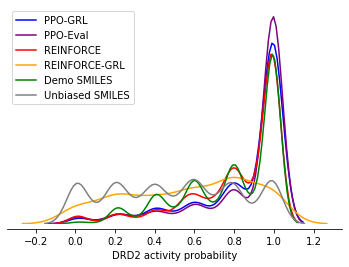

In [12]:
sns.kdeplot(preds_ppo_grl_smiles, label='PPO-GRL', shade=False, color='blue')
sns.kdeplot(preds_ppo_baseline_reward_smiles, label='PPO-Eval', shade=False, color='purple')
sns.kdeplot(preds_reinforce_smiles, label='REINFORCE', shade=False, color='red')
ax = sns.kdeplot(preds_reinforce_grl_smiles, label='REINFORCE-GRL', shade=False, color='orange')
sns.kdeplot(preds_demo_smiles, label='Demo SMILES', shade=False, color='green')
ax = sns.kdeplot(preds_unbiased_smiles, label='Unbiased SMILES', shade=False, color='gray')
plt.xlabel('DRD2 activity probability')
# ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# ax.set_xticks([])
sns.despine(offset=5, left=True, bottom=False)
plt.savefig('drd2/drd2_kde_plots.pdf')
plt.show()

## Convergence plot

In [13]:
ppo_grl_biased = ppo_grl_conv['biased']
ppo_baseline_reward_biased = ppo_baseline_reward_conv['biased']
reinforce_biased = reinforce_conv['biased']
reinforce_grl_biased = reinforce_grl_conv['biased']
demo_vals = reinforce_grl_conv['demo']
unbiased_vals = reinforce_grl_conv['baseline']

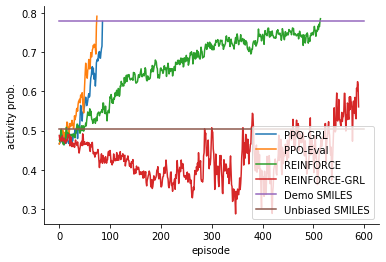

In [16]:
offset = 10
plt.plot(nbu.smoothing_values(ppo_grl_biased, 0.6)[offset:])
plt.plot(nbu.smoothing_values(ppo_baseline_reward_biased, 0.6)[offset:])
plt.plot(nbu.smoothing_values(reinforce_biased, 0.6)[offset:])
plt.plot(nbu.smoothing_values(reinforce_grl_biased, 0.6)[offset:])
plt.plot(demo_vals)
plt.plot(unbiased_vals)
plt.xlabel('episode')
plt.ylabel('activity prob.')
plt.legend(['PPO-GRL','PPO-Eval','REINFORCE','REINFORCE-GRL', 'Demo SMILES', 'Unbiased SMILES'], loc='lower right')
plt.savefig('drd2/drd2_irl_vs_rl_convergence.pdf')
sns.despine()

## t-SNE plot

In [15]:
hparams = {'d_model': 1500,
            'dropout': 0.1919560782374305,
            'monte_carlo_N': 5,
            'use_monte_carlo_sim': True,
            'no_mc_fill_val': 0.0,
            'gamma': 0.97,
            'episodes_to_train': 12,
            'gae_lambda': 0.9228059180288825,
            'ppo_eps': 0.2,
            'ppo_batch': 1,
            'ppo_epochs': 6,
            'entropy_beta': 0.01,
            'use_true_reward': False,
            'baseline_reward': False,
            'reward_params': {'num_layers': 2, 'd_model': 172, 'unit_type': 'lstm', 'demo_batch_size': 128,
                              'irl_alg_num_iter': 3, 'use_attention': False, 'bidirectional': True,
                              'use_validity_flag': True,
                              'dropout': 0.3963193243801649, 'optimizer': 'sgd',
                              'optimizer__global__weight_decay': 0.010945638802254014,
                              'optimizer__global__lr': 0.000256177468757563},
            'agent_params': {'unit_type': 'gru', 'num_layers': 2, 'stack_width': 1500, 'stack_depth': 200,
                             'optimizer': 'adadelta', 'optimizer__global__weight_decay': 0.001428470680331549,
                             'optimizer__global__lr': 0.0008453447466167819},
            'critic_params': {'num_layers': 2, 'd_model': 256, 'unit_type': 'lstm', 'optimizer': 'adadelta',
                              'optimizer__global__weight_decay': 0.7424576981970683, 'dropout':0.,
                              'optimizer__global__lr': 0.0012980019737052746},
            'expert_model_params': {'model_dir': '../model_dir/expert_rnn_bin/',
                                    'd_model': 128,
                                    'rnn_num_layers': 2,
                                    'dropout': 0.8,
                                    'is_bidirectional': True,
                                    'unit_type': 'lstm'}
            }

In [16]:
init_dict = nbu.initialize(hparams, generators['demo_data'], generators['unbiased_data'], True)

In [17]:
# encoder = init_dict['encoder']
# ppo_reward_net_rnn = init_dict['reward_net_rnn']
# ppo_reward_net = init_dict['reward_net']
# ppo_reward_net.load_state_dict(nbu.load_model_weights('../model_dir/DRD2_activity_irelease_stack-rnn_gru_ppo_reward_net2020_07_09__23_58_24_0.778_96.mod'))

In [18]:
# with torch.set_grad_enabled(False):
#     reward_lst, logits_lst = [], []
#     tsne_smiles = ppo_grl_smiles_valid + ppo_grl_smiles_invalid
#     for i in range(0, len(tsne_smiles), 500):
#         inp, valid_vec = nbu.smiles_to_tensor(['<'+s+'>' for s in tsne_smiles[i:i+500]])
#         enc_out = encoder([inp, valid_vec])
#         reward, logits = ppo_reward_net_rnn(enc_out, return_logits=True)
#         reward_lst.append(reward)
#         logits_lst.append(logits)
#     reward = torch.cat(reward_lst)
#     logits = torch.cat(logits_lst)

In [19]:
# logits.shape, reward.shape

In [20]:
# tsne_rep = TSNE(n_components=2).fit_transform(logits.detach().cpu().numpy())
# tsne_data = pd.DataFrame({'x':tsne_rep[:,0], 'y':tsne_rep[:,1]})
# tsne_rep.shape

In [21]:
# plt.figure(figsize=(10,10))
# points = plt.scatter(tsne_data['x'], tsne_data['y'], c=reward.detach().cpu().numpy().reshape(-1,), s=50, cmap="Spectral")
# cb = plt.colorbar(points, ticks=None)
# cb.outline.set_visible(False)
# ax = sns.scatterplot(x="x", y="y", hue=reward.detach().cpu().numpy().reshape(-1,), data=tsne_data, 
#                     legend=False, palette='Spectral', edgecolor='black', linewidth=.01)
# v = []
# # valid SMILES
# while True:
#     va_idx = np.random.randint(len(ppo_grl_smiles_valid))
#     comp = ppo_grl_smiles_valid[va_idx]
#     i = len(v)+1
#     if len(comp) <= 50:
#         v.append(comp)
#         ax.annotate('val-'+str(i), xy=(tsne_data['x'][va_idx], tsne_data['y'][va_idx]), 
#                     xytext=(-20+(i*10),80), 
#                     arrowprops=dict(facecolor='black', arrowstyle='-'),
#                    horizontalalignment='right', verticalalignment='top')
#         if len(v) == 3:
#             break

# inv = []
# # invalid SMILES
# for i in range(3):
#     inv_idx = np.random.randint(len(ppo_grl_smiles_invalid))
#     inv.append(ppo_grl_smiles_invalid[inv_idx])
#     ax.annotate('inv-'+str(i+1), xy=(tsne_data['x'][len(ppo_grl_smiles_valid) + inv_idx], 
#                     tsne_data['y'][len(ppo_grl_smiles_valid) + inv_idx]), 
#                 xytext=(-50+(i*10),70), arrowprops=dict(facecolor='black', arrowstyle='-'),
#                horizontalalignment='right', verticalalignment='top')

# print('selected valid:\n', v)
# print('selected invalid:\n', inv)
# plt.axis('off')
# plt.savefig('drd2/drd2_ppo_grl_tsne.pdf')
# plt.show()

##  Draw random SMILES

In [22]:
vis_mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in set(ppo_grl_smiles_valid) if len(sm) <= 30]
sanitized_gen_mols = [vis_mols[i] for i in np.where(np.array(vis_mols) != None)[0]]
len(sanitized_gen_mols)

679

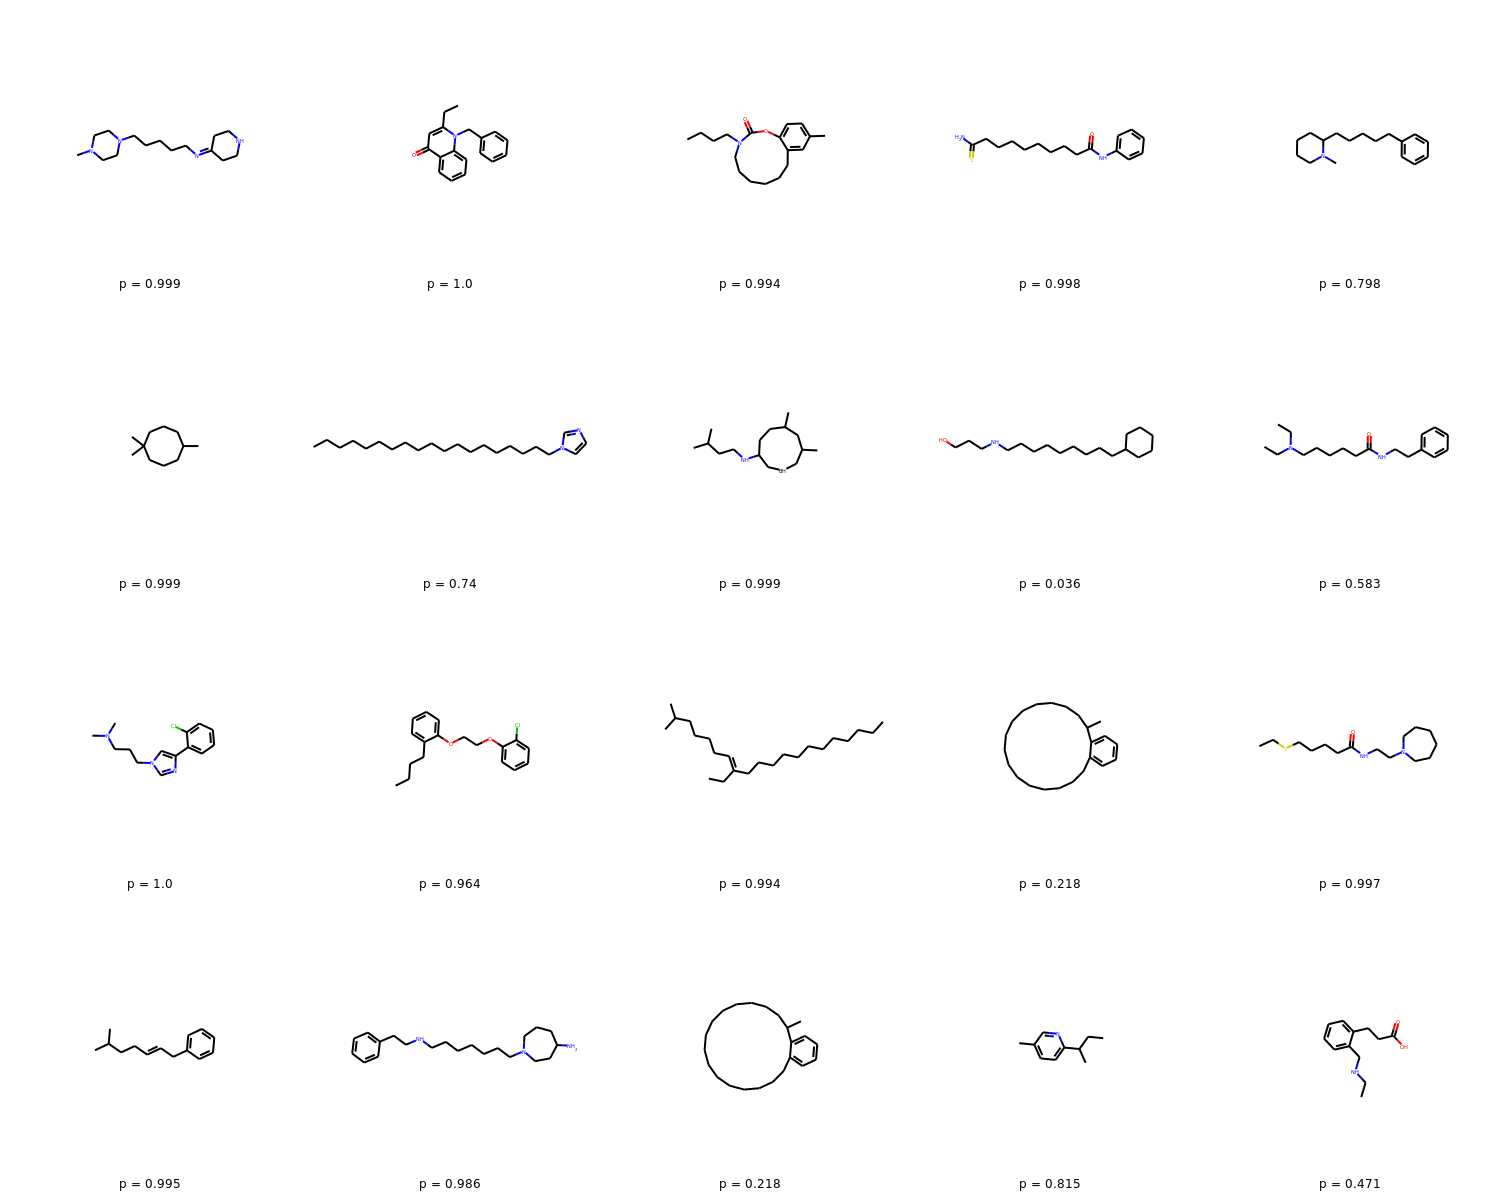

In [23]:
n_to_draw = 20
ind = np.random.randint(0, len(sanitized_gen_mols), n_to_draw)
mols_to_draw = [sanitized_gen_mols[i] for i in ind]
legends = ['p = ' + str(round(float(preds_ppo_grl_smiles[i]), 3)) for i in ind]
Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, subImgSize=(300,300), legends=legends)

In [24]:
for i, mol in enumerate(mols_to_draw):
    print(f'{Chem.MolToSmiles(mol)}\t\t{legends[i]}')

CN1CCN(CCCCCN=C2CCNCC2)CC1		p = 0.999
CCc1cc(=O)c2ccccc2n1Cc1ccccc1		p = 1.0
CCCCN1CCCCCCc2cc(C)ccc2OC1=O		p = 0.994
NC(=S)CCCCCCCCC(=O)Nc1ccccc1		p = 0.998
CN1CCCCC1CCCCCc1ccccc1		p = 0.798
CC1CCCC(C)(C)CCC1		p = 0.999
CCCCCCCCCCCCCCCCCCCn1ccnc1		p = 0.74
CC(C)CCNC1CBCC(C)CC(C)CC1		p = 0.999
OCCCNCCCCCCCCCC1CCCCC1		p = 0.036
CCN(CC)CCCCCC(=O)NCCc1ccccc1		p = 0.583
CN(C)CCCn1cnc(-c2ccccc2Cl)c1		p = 1.0
CCCCc1ccccc1OCCOc1ccccc1Cl		p = 0.964
CCCCCCCCCCCCC(=CCCCCC(C)C)CC		p = 0.994
CC1CCCCCCCCCCCCCCCc2ccccc21		p = 0.218
CCSCCCCC(=O)NCCN1CCCCCC1		p = 0.997
CC(C)CCC=CCc1ccccc1		p = 0.995
NC1CCCN(CCCCCCCNCCc2ccccc2)CC1		p = 0.986
CC1CCCCCCCCCCCCCCCc2ccccc21		p = 0.218
CCC(C)c1ccc(C)cn1		p = 0.815
CCNCc1ccccc1CCC(=O)O		p = 0.471


In [25]:
# Save selected compounds to file
# os.makedirs('./drd2_samples', exist_ok=True)
# for i, mol in enumerate(mols_to_draw):
#     Draw.MolToImageFile(mol, f'./drd2/sample_compound_{i+1}.png')

## Molecule metrics

In [35]:
def mol_metrics(df):
    results = {}
    num_can = 0
    for idx, df_smiles in enumerate([df, df[df['prediction'] >= np.mean(demo_vals)]]):
        new_smiles, valid_vec = canonical_smiles(df_smiles['SMILES'].tolist())
        smiles = []
        for i, s in enumerate(new_smiles):
            if valid_vec[i] == 1:
                smiles.append(s)
        eval_dict = nbu.evaluate(smiles, demo_smiles)
        eval_dict['Num of unique canonical SMILES'] = len(set(smiles))
        if idx==0:
            num_can = len(smiles)
        eval_dict['percentage of valid'] = df_smiles.shape[0] / 10000. * 100.
        if idx==1:            
            eval_dict['percentage in threshold (canonical)'] = len(smiles) / num_can
        results['no_threshold' if idx==0 else 'with_threshold'] = eval_dict
    return results

In [36]:
mol_metrics(preds_ppo_grl_eval)

{'no_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.18857035237130135,
  'internal_diversity': 0.8867909614983127,
  'conciseness': 1.0,
  'solubility': 0.8866028578764165,
  'naturalness': 0.6737815877250535,
  'synthesizability': 0.5794447603940279,
  'druglikeliness': 0.2707620798674448,
  'Num of unique canonical SMILES': 3264,
  'percentage of valid': 32.71},
 'with_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.10441147144312585,
  'internal_diversity': 0.8636858200293797,
  'conciseness': 1.0,
  'solubility': 0.9391150805497605,
  'naturalness': 0.7094130605091603,
  'synthesizability': 0.5078983303857787,
  'druglikeliness': 0.18110376241846032,
  'Num of unique canonical SMILES': 2406,
  'percentage of valid': 24.12,
  'percentage in threshold (canonical)': 0.7371323529411765}}

In [37]:
mol_metrics(preds_ppo_baseline_reward_eval)

{'no_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.18269190953756917,
  'internal_diversity': 0.8776093409541392,
  'conciseness': 1.0,
  'solubility': 0.885274109286915,
  'naturalness': 0.7222516475882325,
  'synthesizability': 0.5211282766319629,
  'druglikeliness': 0.23629006742960168,
  'Num of unique canonical SMILES': 4538,
  'percentage of valid': 45.440000000000005},
 'with_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.09189507690386499,
  'internal_diversity': 0.8485270192092526,
  'conciseness': 1.0,
  'solubility': 0.9474323668714805,
  'naturalness': 0.7558392571726208,
  'synthesizability': 0.45751416444805754,
  'druglikeliness': 0.14441089242330132,
  'Num of unique canonical SMILES': 3465,
  'percentage of valid': 34.68,
  'percentage in threshold (canonical)': 0.7635522256500661}}

In [38]:
mol_metrics(preds_reinforce_eval)

{'no_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.3250513101127702,
  'internal_diversity': 0.9042709966824587,
  'conciseness': 1.0,
  'solubility': 0.8016245803379475,
  'naturalness': 0.7025041489348428,
  'synthesizability': 0.7178129985022191,
  'druglikeliness': 0.44342409317476356,
  'Num of unique canonical SMILES': 7393,
  'percentage of valid': 74.05000000000001},
 'with_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.22233497499542032,
  'internal_diversity': 0.8880668667951545,
  'conciseness': 1.0,
  'solubility': 0.8366710368610052,
  'naturalness': 0.7154006488716068,
  'synthesizability': 0.7062561793113303,
  'druglikeliness': 0.39175670298389553,
  'Num of unique canonical SMILES': 5005,
  'percentage of valid': 50.1,
  'percentage in threshold (canonical)': 0.6769917489517111}}

In [39]:
mol_metrics(preds_reinforce_grl_eval)

{'no_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.5132832093923956,
  'internal_diversity': 0.9239257580152366,
  'conciseness': 1.0,
  'solubility': 0.8463718541727862,
  'naturalness': 0.7941316737207141,
  'synthesizability': 0.29328565126728745,
  'druglikeliness': 0.30366703501285053,
  'Num of unique canonical SMILES': 541,
  'percentage of valid': 5.42},
 'with_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.22269208823577522,
  'internal_diversity': 0.9073351412337247,
  'conciseness': 1.0,
  'solubility': 0.9286994111815453,
  'naturalness': 0.8527846725814764,
  'synthesizability': 0.21108535413756105,
  'druglikeliness': 0.19386637337461332,
  'Num of unique canonical SMILES': 201,
  'percentage of valid': 2.01,
  'percentage in threshold (canonical)': 0.37153419593345655}}

In [40]:
mol_metrics(preds_demo)

{'no_threshold': {'novelty': 0.9419,
  'hard_novelty': 0.9419,
  'soft_novelty': 0.9593299999999999,
  'external_diversity': 0.08888893770764128,
  'internal_diversity': 0.8969069140069144,
  'conciseness': 1.0,
  'solubility': 0.7767210383965386,
  'naturalness': 0.5357496152445249,
  'synthesizability': 0.637410211161941,
  'druglikeliness': 0.6035345842617676,
  'Num of unique canonical SMILES': 7732,
  'percentage of valid': 100.0},
 'with_threshold': {'novelty': 0.9421865154379332,
  'hard_novelty': 0.9421865154379332,
  'soft_novelty': 0.9595305608065533,
  'external_diversity': 0.08287231349292265,
  'internal_diversity': 0.8963335866854835,
  'conciseness': 1.0,
  'solubility': 0.7929836258996398,
  'naturalness': 0.5243932460374882,
  'synthesizability': 0.6417687210205002,
  'druglikeliness': 0.5884568891956599,
  'Num of unique canonical SMILES': 4941,
  'percentage of valid': 63.480000000000004,
  'percentage in threshold (canonical)': 0.6348}}

In [41]:
mol_metrics(preds_unbiased)

{'no_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.38132219434661285,
  'internal_diversity': 0.9172257350533534,
  'conciseness': 1.0,
  'solubility': 0.6609464611090811,
  'naturalness': 0.557850558734029,
  'synthesizability': 0.6367046437546721,
  'druglikeliness': 0.602456357814084,
  'Num of unique canonical SMILES': 2048,
  'percentage of valid': 100.0},
 'with_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.41239655986815443,
  'internal_diversity': 0.9185673804106566,
  'conciseness': 1.0,
  'solubility': 0.6914433075265779,
  'naturalness': 0.5863343283271654,
  'synthesizability': 0.5883674291722466,
  'druglikeliness': 0.6089190478475329,
  'Num of unique canonical SMILES': 528,
  'percentage of valid': 26.58,
  'percentage in threshold (canonical)': 0.2658}}

## RNN hidden neurons examination

In [33]:
# def plot_heatmap(smiles_list, logits, neuron=None, save=False):
#     if neuron is None:
#         neuron = np.random.randint(logits.shape[-1])
#     print(f'Plotting for neuron {neuron}')
#     for i, smiles in enumerate(smiles_list):
#         arr = logits[:len(smiles), i, neuron].reshape(1, len(smiles))
#         chars = np.array([c for c in smiles]).reshape(1,-1)
#         fig = plt.figure(figsize=(200,4))
#         sns.heatmap(arr, annot=chars, fmt='', cbar=False, 
#                     cmap=sns.color_palette("bwr", 10), annot_kws={'size':100, 'fontweight':'normal'},
#                    xticklabels=False, yticklabels=False, square=True)
#         if save:
#             os.makedirs(f'drd2/neuron_{neuron}', exist_ok=True)
#             plt.savefig(f'drd2/neuron_{neuron}/{i}.png')
#         plt.show()

In [34]:
# plot_heatmap(ppo_samples[:10], ppo_samples_neurons[:,:10,:])